### DSC 680 Week  : 
#### Project 1
#### Author: Brian Reppeto 12/7/2024

### Import necessary libraries for handling data, visualization, and machine learning

In [64]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

### Load Datasets

In [65]:
# Load the datasets

stores = pd.read_csv("archive/stores.csv")
features = pd.read_csv("archive/features.csv")
sales = pd.read_csv("archive/train.csv")

### Data Manipulation and Preprocessing

In [66]:
# Fill missing values

features['CPI'] = features['CPI'].fillna(features['CPI'].mean())
features['Unemployment'] = features['Unemployment'].fillna(features['Unemployment'].mean())

markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
features[markdown_cols] = features[markdown_cols].fillna(0)

# Merge datasets

data = pd.merge(features, sales, on=['Store', 'Date', 'IsHoliday'], how='inner')
final_data = pd.merge(data, stores, on='Store', how='inner')

# Convert 'Date' to datetime and sort

final_data['Date'] = pd.to_datetime(final_data['Date'], errors='coerce')
final_data = final_data.sort_values(by='Date').dropna(subset=['Date'])

# Check for remaining missing values

if final_data.isnull().any().any():
    print("Warning: There are still missing values!")


### Exploratory Data Analysis (EDA) / Illustrations

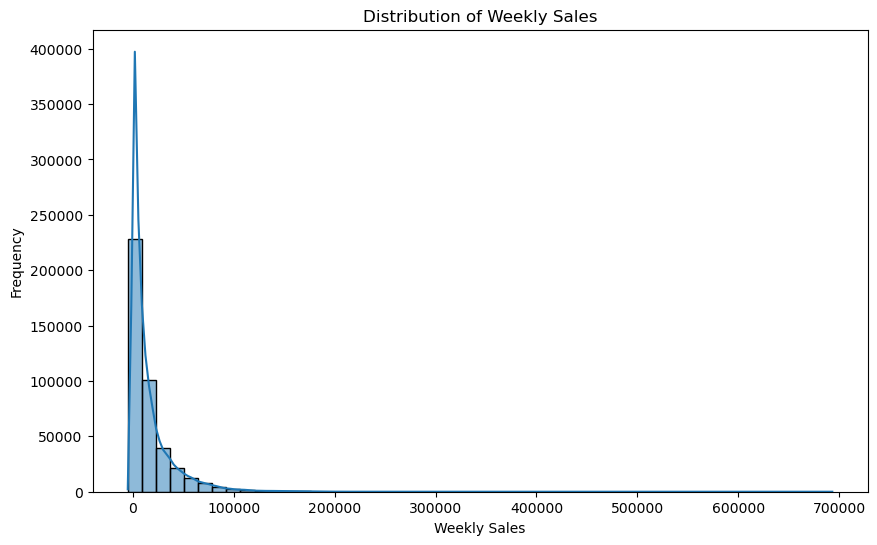

In [67]:
# Weekly Sales Distribution

plt.figure(figsize=(10, 6))
sns.histplot(final_data['Weekly_Sales'], bins=50, kde=True)
plt.title("Distribution of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.show()

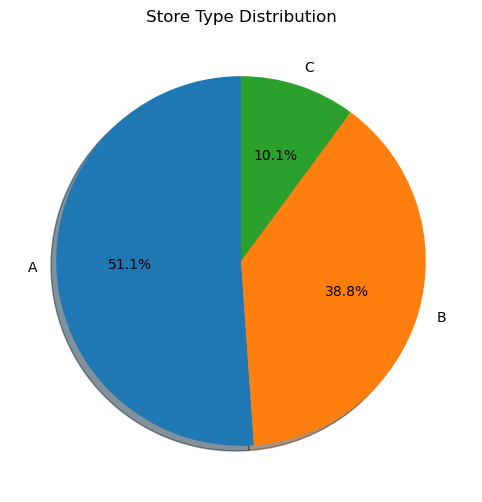

In [68]:
# Store Type Pie Chart

store_types = final_data['Type'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(store_types, labels=store_types.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title("Store Type Distribution")
plt.show()

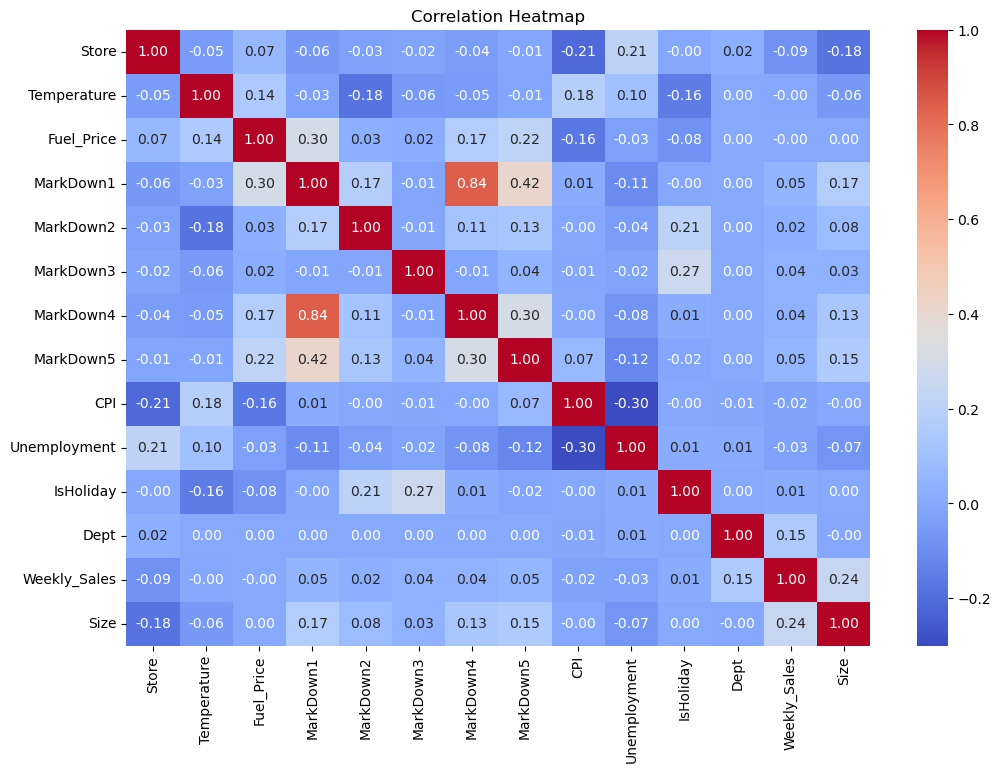

In [69]:
# Correlation Heatmap

plt.figure(figsize=(12, 8))
corr_matrix = final_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

###  Feature Engineering

In [70]:
final_data['Year'] = final_data['Date'].dt.year
final_data['Day'] = final_data['Date'].dt.day
final_data['Days to Next Christmas'] = (
    pd.to_datetime(final_data['Year'].astype(str) + "-12-31") - final_data['Date']).dt.days

final_data = pd.get_dummies(final_data, columns=['Type'], drop_first=True)

### Prepare Data for Modeling

In [71]:
X = final_data.drop(columns=['Weekly_Sales', 'Date', 'IsHoliday'])
y = final_data['Weekly_Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize numeric features only
scaler = StandardScaler()
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

### Modeling and Evaluation

In [72]:
models = {
    "KNN Regressor": KNeighborsRegressor(n_neighbors=10, n_jobs=4),
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=400, max_depth=15, n_jobs=4, random_state=0),
    "XGB Regressor": XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=6, learning_rate=0.5, n_jobs=4),
    "Extra Trees": ExtraTreesRegressor(n_estimators=30, n_jobs=4, random_state=0),}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    accuracy = 100 - (mae / y_test.mean()) * 100
    results.append((name, mae, rmse, accuracy))
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, Accuracy={accuracy:.2f}%")

KNN Regressor: MAE=12542.75, RMSE=20472.31, Accuracy=21.35%
Decision Tree: MAE=1762.28, RMSE=4547.65, Accuracy=88.95%
Random Forest: MAE=1887.23, RMSE=4265.29, Accuracy=88.17%
XGB Regressor: MAE=1913.56, RMSE=3784.85, Accuracy=88.00%
Extra Trees: MAE=1422.72, RMSE=4328.78, Accuracy=91.08%


### Visualize Model Performance

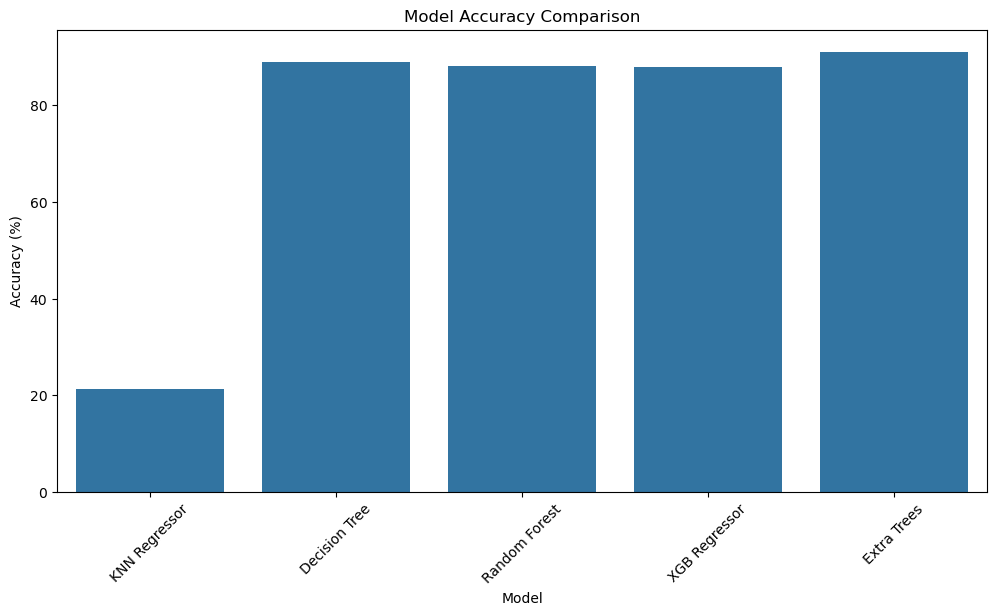

In [73]:
model_results = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'Accuracy'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=model_results)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

### Ensemble Averaging

In [74]:
top_models = ['Decision Tree', 'Random Forest', 'XGB Regressor', 'Extra Trees']
predictions = [models[model].predict(X_test) for model in top_models]
ensemble_pred = np.mean(predictions, axis=0)

ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_accuracy = 100 - (ensemble_mae / y_test.mean()) * 100

print(f"Ensemble: MAE={ensemble_mae:.2f}, RMSE={ensemble_rmse:.2f}, Accuracy={ensemble_accuracy:.2f}%")

Ensemble: MAE=1403.56, RMSE=3360.11, Accuracy=91.20%
